# **utils.py**

In [ ]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter


def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
               or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
               < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms


def mean_average_precision(
        pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        # TP_cumsum & FP_cmsum is a Tensor with multiple values.
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        # At each index it contain precision & recall for a sample.
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        # concating 0 & 1 at the start
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration.
        # It integrates y wrt x.
        ap = torch.trapz(y=precisions, x=recalls)
        average_precisions.append(ap)

    return sum(average_precisions) / len(average_precisions)


def plot_image(image, boxes):
    # pascal voc labels as per id
    pascal_voc_labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                         'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
                         'dog', 'horse', 'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor']

    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

    # Each box is of format : [class_label,object_prob,x,y,w,h]

    # Create a Rectangle potch
    for box in boxes:
        box_label = pascal_voc_labels[int(box[0])]
        obj_prob = round((box[1] * 100), 1)
        bbox_label = box_label + " : " + str(obj_prob) + "%"

        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1.5,
            edgecolor="lime",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

        # Displays object name on bbox
        rx, ry = rect.get_xy()
        ax.annotate(bbox_label, (rx, ry), color='white', backgroundcolor='lime',
                    weight='bold', fontsize=6, ha='left', va='bottom')

    plt.show()


# Converts the labels from relative to each
# cell, to relative to the entire image.
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes


# Given loader and model, returns all predicted & ground truth bboxes.
# We'll use it to evaluate the model mAP.
def get_bboxes(
        loader,
        model,
        iou_threshold,
        threshold,
        pred_format="cells",
        box_format="midpoint",
        device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            # We'll bring all predicted & ground truth boxes to format :
            # [train_idx, class_prediction, prob_score, x1, y1, x2, y2]

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


# Functions for saving the model
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])


# **model.py**

In [ ]:

"""
Implementation of Yolo (v1) architecture
with slight modification with added BatchNorm.

==> MODEL SUMMARY :

Total params: 85,787,534
Trainable params: 85,787,534
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.30
Forward/backward pass size (MB): 436.81
Params size (MB): 327.25
Estimated Total Size (MB): 766.36
----------------------------------------------------------------
"""


import torch
import torch.nn as nn

""" 
Information about architecture config:
Tuple is structured by (kernel_size, filters, stride, padding) 
"M" is simply maxpooling with stride 2x2 and kernel 2x2
List is structured by tuples and lastly int with number of repeats
"""

architecture_config = [

    # (kernel_size, filters, stride, padding)

    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))


"""
The model takes a batch of Images : (Batch_size,Channels,Height,Width).
Flattened_tensor = S * S * (C + B * 5)
Returns a tensor of shape : (Batch_size,Flattened_tensor).
The Flattened tensor can be reshaped to SxSx(C + B*5) 
to get the output tensor for each image.
"""


class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )


# **loss.py**

In [ ]:
"""
Implementation of Yolo Loss Function from the original yolo paper
"""

import torch
import torch.nn as nn

"""
Output of each grid cell with 20 classes & 2 bounding boxes : 
[0,1,2...19,P1,X1,Y1,X2,Y2,P2,X1,Y1,X2,Y2]
"""


class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) ) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * ((bestbox * predictions[..., 26:30]+ (1 - bestbox) * predictions[..., 21:25]))

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(torch.abs(box_predictions[..., 2:4] + 1e-6))
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),)

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21])

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        # max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        # no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        # )

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2, ),
            torch.flatten(exists_box * target[..., :20], end_dim=-2, ),
        )

        loss = (self.lambda_coord * box_loss  # first two rows in paper
                + object_loss  # third row in paper
                + self.lambda_noobj * no_object_loss  # forth row
                + class_loss )  # fifth row

        return loss


# **dataset.py**

In [ ]:

"""
Creates a Pytorch dataset to load the Pascal VOC dataset
"""

import torch
import os
import pandas as pd
from PIL import Image


"""
pascal_voc_labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                     'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
                     'dog', 'horse', 'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']
"""


# Takes 3 main parameters :
# 1] csv file containing img & label file names.
# 2] dir paths of where images & their labels are located.
# 3] s,b,c - number of grids,bboxes & classes.

# It converts output of each image into (SxSx5B+C) format,since our
# model will produce the output tensor of same format for each image.
# Pascal Voc gives bbox labels relative to the entire image,we convert
# them relative to each cell of the final grid since each cell is responsible for object prediction.
# Each cell outputs : [0,0,0,1...0,Obj_Prob1,X1,Y1,W1,H1,Obj_Prob2,X2,Y2,W2,H2] in our case.

class VOCDataset(torch.utils.data.Dataset):
    def __init__(
            self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):

        # Returns a single image & its label of shape (SxSx5B+C)

        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:

            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)

            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!
            if label_matrix[i, j, 20] == 0:
                # Set that there exists an object
                label_matrix[i, j, 20] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 21:25] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix



# **train.py**

In [ ]:

"""
Main file for training Yolo model on Pascal VOC dataset
"""

import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader

seed = 123
torch.manual_seed(seed)

# Hyperparameters etc.
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
print("Device is : ",DEVICE)
BATCH_SIZE = 10 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 100
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "YoloV1_Weights.pth"
IMG_DIR = "/content/drive/MyDrive/Pascal VOC Dataset/images"
LABEL_DIR = "/content/drive/MyDrive/Pascal VOC Dataset/labels"

#======================================================================

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():
    
    print("Defining the model...")
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    print("Fetching Data for DataLoaders...")

    train_dataset = VOCDataset(r"/content/drive/MyDrive/Pascal VOC Dataset/1000Examples.csv",transform=transform,img_dir=IMG_DIR,label_dir=LABEL_DIR)

    test_dataset = VOCDataset(r"/content/drive/MyDrive/Pascal VOC Dataset/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,)

    train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,pin_memory=PIN_MEMORY,shuffle=True,drop_last=True,)

    test_loader = DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,pin_memory=PIN_MEMORY,shuffle=True,drop_last=True)


    for epoch in range(EPOCHS):

        print("EPOCH : ",epoch)

        #=============================================

        # if epoch%3==0:
        #     # plots image with bboxes
        #     images_to_plot = 5
        #     for x, y in train_loader:
        #         x = x.to(DEVICE)
        #         for idx in range(images_to_plot):
        #             bboxes = cellboxes_to_boxes(model(x))
        #             bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        #             plot_image(x[idx].permute(1, 2, 0).to("cpu"), bboxes)


        #=============================================

        pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4)

        mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
        print(f"Train mAP: {mean_avg_prec}")

        #=============================================
        
        # Saving model params at checkpoint
        if mean_avg_prec > 0.9 or epoch%10==0:
           print("Checkpoint at epoch : ",epoch)
           checkpoint = {
               "state_dict": model.state_dict(),
           }
           save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
           import time
           time.sleep(10)

        #=============================================

        train_fn(train_loader, model, optimizer, loss_fn)


Device is :  cuda


In [ ]:
main()

Defining the model...
Fetching Data for DataLoaders...
EPOCH :  0
Train mAP: 0.0
Checkpoint at epoch :  0
=> Saving checkpoint


100%|██████████| 100/100 [00:53<00:00,  1.87it/s, loss=180]

Mean loss was 309.5179525756836
EPOCH :  1



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.00047758439905010164


100%|██████████| 100/100 [00:53<00:00,  1.87it/s, loss=155]

Mean loss was 153.62117637634276
EPOCH :  2



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.0018209668342024088


100%|██████████| 100/100 [00:53<00:00,  1.87it/s, loss=85.7]

Mean loss was 115.92641273498535
EPOCH :  3



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.00671599293127656


100%|██████████| 100/100 [00:53<00:00,  1.87it/s, loss=79.1]

Mean loss was 101.25330898284912
EPOCH :  4



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.00956687144935131


100%|██████████| 100/100 [00:53<00:00,  1.87it/s, loss=84]

Mean loss was 93.01478240966797
EPOCH :  5



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.03653015196323395


100%|██████████| 100/100 [00:53<00:00,  1.87it/s, loss=108]

Mean loss was 84.31695957183838
EPOCH :  6



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.04996294155716896


100%|██████████| 100/100 [00:53<00:00,  1.87it/s, loss=64.9]

Mean loss was 80.4682702255249
EPOCH :  7



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.06726747751235962


100%|██████████| 100/100 [00:53<00:00,  1.87it/s, loss=50.6]

Mean loss was 76.32534210205078
EPOCH :  8



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.12033423036336899


100%|██████████| 100/100 [00:53<00:00,  1.87it/s, loss=50.5]

Mean loss was 71.03463886260987
EPOCH :  9



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.16748550534248352


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=68.1]

Mean loss was 66.88214908599853
EPOCH :  10


Train mAP: 0.22257015109062195
Checkpoint at epoch :  10
=> Saving checkpoint


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=94.2]

Mean loss was 62.42890161514282
EPOCH :  11



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.25794440507888794


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=62.6]

Mean loss was 58.42151382446289
EPOCH :  12



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.3737719655036926


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=36.1]

Mean loss was 57.85357048034668
EPOCH :  13



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.3897015452384949


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=64.2]

Mean loss was 54.734623985290526
EPOCH :  14



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.38523250818252563


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=56.7]

Mean loss was 55.024094848632814
EPOCH :  15



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.449456125497818


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=50.4]

Mean loss was 53.811909980773926
EPOCH :  16



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.47602948546409607


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=96.2]

Mean loss was 51.936433238983156
EPOCH :  17



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.48844942450523376


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=49.2]

Mean loss was 49.760976734161375
EPOCH :  18



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.5656951665878296


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=42.1]

Mean loss was 48.06496213912964
EPOCH :  19



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.5634304881095886


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=50.3]

Mean loss was 46.822078247070316
EPOCH :  20


Train mAP: 0.5725409388542175
Checkpoint at epoch :  20
=> Saving checkpoint


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=57.3]

Mean loss was 46.09321475982666
EPOCH :  21



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.5851906538009644


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=31.6]

Mean loss was 45.06600727081299
EPOCH :  22



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.5999112725257874


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=56.5]

Mean loss was 43.115300025939945
EPOCH :  23



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.5729199647903442


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=21.5]

Mean loss was 42.79325563430786
EPOCH :  24



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.6255884170532227


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=27.4]

Mean loss was 41.89934463500977
EPOCH :  25



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.5975240468978882


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=40]

Mean loss was 40.583193645477294
EPOCH :  26



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.6039204597473145


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=47.4]

Mean loss was 40.185040893554685
EPOCH :  27



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.6618698835372925


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=26.8]

Mean loss was 37.62640562057495
EPOCH :  28



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.6596411466598511


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=57.8]

Mean loss was 37.1069987487793
EPOCH :  29



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.6767916083335876


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=28.4]

Mean loss was 34.88339685440064
EPOCH :  30


Train mAP: 0.6984769701957703
Checkpoint at epoch :  30
=> Saving checkpoint


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=25.7]

Mean loss was 35.021532649993894
EPOCH :  31



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.6999605894088745


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=25.2]

Mean loss was 35.029833211898804
EPOCH :  32



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.687717616558075


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=21.7]

Mean loss was 34.41057796478272
EPOCH :  33



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.6862403154373169


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=44.2]

Mean loss was 33.79387979507446
EPOCH :  34



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7125868201255798


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=14.7]

Mean loss was 33.269632511138916
EPOCH :  35



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7291395664215088


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=35]

Mean loss was 31.27093885421753
EPOCH :  36



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7159556150436401


100%|██████████| 100/100 [00:53<00:00,  1.87it/s, loss=22.9]

Mean loss was 31.461437826156615
EPOCH :  37



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7472267150878906


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=29.2]

Mean loss was 29.608097944259644
EPOCH :  38



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7642971873283386


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=28.4]

Mean loss was 27.980643577575684
EPOCH :  39



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7684317827224731


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=22.4]

Mean loss was 28.086560611724853
EPOCH :  40


Train mAP: 0.7800103425979614
Checkpoint at epoch :  40
=> Saving checkpoint


100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=25.7]

Mean loss was 27.247007036209105
EPOCH :  41



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7536226511001587


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=18.1]

Mean loss was 27.957940101623535
EPOCH :  42



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7498660683631897


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=27.4]

Mean loss was 27.414102001190187
EPOCH :  43



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7378524541854858


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=44.1]

Mean loss was 28.40981453895569
EPOCH :  44



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7454423308372498


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=19.7]

Mean loss was 27.900666522979737
EPOCH :  45



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7721913456916809


100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=23.6]

Mean loss was 24.247369594573975
EPOCH :  46



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8012282252311707


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=28]

Mean loss was 23.886578016281128
EPOCH :  47



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7780624628067017


100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=15.5]

Mean loss was 24.30972776412964
EPOCH :  48



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7470394372940063


100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=19.7]

Mean loss was 24.043322772979735
EPOCH :  49



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7811316251754761


100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=44.6]

Mean loss was 22.20355330467224
EPOCH :  50


Train mAP: 0.782873809337616
Checkpoint at epoch :  50
=> Saving checkpoint


100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=29.3]

Mean loss was 22.12286497116089
EPOCH :  51



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7805925607681274


100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=11.6]

Mean loss was 22.958224506378173
EPOCH :  52



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7720085382461548


100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=17.4]

Mean loss was 21.383127164840698
EPOCH :  53



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7655938863754272


100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=18.1]

Mean loss was 20.886109895706177
EPOCH :  54



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7973473072052002


100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=25.4]

Mean loss was 20.534920568466188
EPOCH :  55



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7934394478797913


100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=16.7]

Mean loss was 20.52616050720215
EPOCH :  56



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.7858840227127075


100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=15.7]

Mean loss was 21.466951179504395
EPOCH :  57



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8023818135261536


100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=27.7]

Mean loss was 19.785080432891846
EPOCH :  58



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8061068654060364


100%|██████████| 100/100 [00:54<00:00,  1.84it/s, loss=28.7]

Mean loss was 19.59098391532898
EPOCH :  59



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.819830060005188


100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=19.1]

Mean loss was 20.32791911125183
EPOCH :  60


Train mAP: 0.8035508394241333
Checkpoint at epoch :  60
=> Saving checkpoint


100%|██████████| 100/100 [00:54<00:00,  1.84it/s, loss=18.3]

Mean loss was 18.213280601501467
EPOCH :  61



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.816582977771759


100%|██████████| 100/100 [00:54<00:00,  1.84it/s, loss=14.5]

Mean loss was 19.895621957778932
EPOCH :  62



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8183767199516296


100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=11.3]

Mean loss was 19.070182733535766
EPOCH :  63



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8239301443099976


100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=15.1]

Mean loss was 17.202322363853455
EPOCH :  64



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8248199224472046


100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=16.2]

Mean loss was 17.288313188552856
EPOCH :  65



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8508346676826477


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=9.26]

Mean loss was 16.45720821380615
EPOCH :  66



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8424727320671082


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=21.5]

Mean loss was 16.595713510513306
EPOCH :  67



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8329081535339355


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=11]

Mean loss was 16.62168808937073
EPOCH :  68



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.823147177696228


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=15.4]

Mean loss was 16.709531631469726
EPOCH :  69



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8048323392868042


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=14.2]

Mean loss was 17.815638070106505
EPOCH :  70


Train mAP: 0.8059722185134888
Checkpoint at epoch :  70
=> Saving checkpoint


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=19.9]

Mean loss was 17.348516521453856
EPOCH :  71



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.812617301940918


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=9.67]

Mean loss was 16.892892484664916
EPOCH :  72



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8348590135574341


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=7.23]

Mean loss was 14.797421255111693
EPOCH :  73



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8410249948501587


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=9.97]

Mean loss was 14.147625126838683
EPOCH :  74



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.822544276714325


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=9.84]

Mean loss was 14.302226514816285
EPOCH :  75



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8410066366195679


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=19.5]

Mean loss was 14.74561185836792
EPOCH :  76



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8567406535148621


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=10.2]

Mean loss was 14.76475492477417
EPOCH :  77



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8324071168899536


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=13.6]

Mean loss was 14.029949989318848
EPOCH :  78



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8345195055007935


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=7.41]

Mean loss was 12.789233002662659
EPOCH :  79



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8748431205749512


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=11.5]

Mean loss was 13.116358661651612
EPOCH :  80


Train mAP: 0.829160213470459
Checkpoint at epoch :  80
=> Saving checkpoint


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=22.8]

Mean loss was 13.387522072792054
EPOCH :  81



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8186790347099304


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=12.2]

Mean loss was 13.108471555709839
EPOCH :  82



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8300720453262329


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=5.91]

Mean loss was 13.124074130058288
EPOCH :  83



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8271325826644897


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=11.8]

Mean loss was 14.237373719215393
EPOCH :  84



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8283594846725464


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=16.1]

Mean loss was 13.879443221092224
EPOCH :  85



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8614206314086914


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=17.6]

Mean loss was 13.490000381469727
EPOCH :  86



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.84637850522995


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=6.34]

Mean loss was 12.352353076934815
EPOCH :  87



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8605726361274719


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=7.31]

Mean loss was 12.147620954513549
EPOCH :  88



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8405532836914062


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=9.53]

Mean loss was 12.951604108810425
EPOCH :  89



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8409096002578735


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=7.75]

Mean loss was 12.228147773742675
EPOCH :  90


Train mAP: 0.844953715801239
Checkpoint at epoch :  90
=> Saving checkpoint


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=8.4]

Mean loss was 11.874021825790406
EPOCH :  91



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8313206434249878


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=17.4]

Mean loss was 11.343675365447998
EPOCH :  92



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.878153920173645


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=8.04]

Mean loss was 10.944299516677857
EPOCH :  93



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8652924299240112


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=7.28]

Mean loss was 11.050949597358704
EPOCH :  94



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8421001434326172


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=7.14]

Mean loss was 10.929749021530151
EPOCH :  95



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8611408472061157


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=11.1]

Mean loss was 10.498226308822632
EPOCH :  96



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8529070615768433


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=9.35]

Mean loss was 10.640713920593262
EPOCH :  97



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8656851053237915


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, loss=17.4]

Mean loss was 12.694035015106202
EPOCH :  98



  0%|          | 0/100 [00:00<?, ?it/s]

Train mAP: 0.8431111574172974


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=6.5]

Mean loss was 11.75137800693512
EPOCH :  99


Train mAP: 0.9008848071098328
Checkpoint at epoch :  99
=> Saving checkpoint


100%|██████████| 100/100 [00:53<00:00,  1.85it/s, loss=7.02]

Mean loss was 10.812437109947204


# **Yolo_API.py**

In [15]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches


def plot_image(image, boxes, font_size=6):
    # pascal voc labels as per id
    pascal_voc_labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                         'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
                         'dog', 'horse', 'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor']

    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

    # Each box is of format : [class_label,object_prob,x,y,w,h]

    objects_detected = []

    # Create a Rectangle potch
    for box in boxes:
        box_label = pascal_voc_labels[int(box[0])]
        objects_detected.append(box_label)
        obj_prob = round((box[1] * 100), 1)
        bbox_label = box_label + " : " + str(obj_prob) + "%"

        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1.5,
            edgecolor="lime",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

        # Displays object name on bbox
        rx, ry = rect.get_xy()
        ax.annotate(bbox_label, (rx, ry), color='white', backgroundcolor='lime',
                    weight='bold', fontsize=font_size, ha='left', va='bottom')

    if len(objects_detected) < 1:
        print("NO OBJECTS FROM DETECTION LIST DETECTED.")
    else:
        print("OBJECTS DETECTED IN IMAGE : ", objects_detected)
    plt.show()


# Takes an Image Path as input and plots bounding boxes on
# objects detected on image,then displays the image back.
def detect_objects(image_path, font_size=6, weights_path=None):
    assert type(image_path) == str, "Image path should be a string."
    if type(weights_path) != str:
        raise Exception("weights_path parameter needs to be a string,go through Github README.md "
                        "file of this project to know how to download the weights.")

    img = cv2.imread(image_path)
    # Input shape of Yolo V1
    input_shape = (448, 448)
    img = cv2.resize(img, input_shape)

    # reshaping image as needed by pytorch
    frame = np.array(img)
    frame = frame.reshape(-1, 3, input_shape[0], input_shape[1])
    frame = torch.Tensor(frame)

    # ================================================

    model = Yolov1(split_size=7, num_boxes=2, num_classes=20)

    # Loading pretrained weights
    if weights_path:
        print("Loading Pre-trained weights...")
        # If Gpu available
        if torch.cuda.is_available():
            checkpoint = torch.load(weights_path)
            model.load_state_dict(checkpoint['state_dict'])
        else:
            checkpoint = torch.load(weights_path, map_location=torch.device('cpu'))
            model.load_state_dict(checkpoint['state_dict'])

    # Predicting bboxes on the image.
    bboxes = model(frame)

    bboxes = cellboxes_to_boxes(bboxes)
    bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
    plot_image(img, bboxes, font_size)


# **main.py**

Loading Pre-trained weights...
OBJECTS DETECTED IN IMAGE :  ['bicycle']


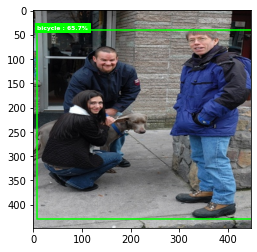

In [21]:
'''
==============
IMPORTANT NOTE :
=============

This is an Implementation of Object Detection using YOLO V1 trained on Pascal VOC Dataset.
==> MODEL SUMMARY :
Total params: 85,787,534
Trainable params: 85,787,534
Non-trainable params: 0
----------------------------------------------------------------
Forward/backward pass size (MB): 436.81
Params size (MB): 327.25
Estimated Total Size (MB): 766.36
----------------------------------------------------------------

detection_list = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                     'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
                     'dog', 'horse', 'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

This model can detect only the objects listed in the above detection list.

==> THE MODEL MAY SOMETIMES PRODUCE INCORRECT PREDICTIONS & NEEDS TO TRAINED
FOR MORE EPOCHS TO INCREASE ACCURACY.

==> Images are resized to 448x448 since the model accepts a fixed size image as input.

Each bounding box displays the object name it has detected and the
probability of an object being present inside the bounding box.

(GPU RECOMMENDED FOR RUNNING THE MODEL)

'''

# -------------------------------------------------------------------------

'''
Below is an simple API function of the model which takes the location of your image as
input & then displays the image back with detected objects represented under bounding boxes.

The function also takes an important parameter 'weights_path' which is the path where the 
pretrained weights of the model are located.Given a path it'll load 
those learned parameters into the model (IMPORTANT TO SPECIFY ELSE MODEL WONT WORK)
'''

# Insert the location of your Image below
IMAGE_PATH = r'/content/drive/MyDrive/Pascal VOC Dataset/images/000021.jpg'

# Insert the location of weights file below
WEIGHTS_PATH = r'/content/YoloV1_Weights.pth'

detect_objects(image_path=IMAGE_PATH,weights_path=WEIGHTS_PATH)
